# MSDS7333 Case Study 2: Signal Frontier Analysis
## Calculating a Momentum Portfolio
Julien Bataillard
Jared Law
Dennis Murray
Cory Nichols

In [1]:
import datetime as dt

import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set date range
date_time_start = dt.datetime(2016, 1, 1)
date_time_end = dt.datetime(2017, 6, 1)

In [3]:
def get_portfolio():
    ''' Get portfolio of stocks using buggy Yahoo'''
    
    port = pd.DataFrame()
    names = ['DPZ', 'PZZA', 'YUM', 'FRSH', 'MCD', 'KHC', 'PLAY']
    for stock in names:
        while True:
            try:
                port[stock] = web.get_data_yahoo(stock, date_time_start, date_time_end)['Adj Close']
                break
            except:
                print('Unable to read stock: {0}, trying again'.format(stock))
    return port

px = get_portfolio()

Unable to read stock: FRSH, trying again
Unable to read stock: MCD, trying again


In [4]:
# daily adjusted close prices for pizza portfolio 
px.head()

,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
Date,,,,,,,
2016-01-04,107.016136,53.639576,49.635929,10.92,111.198700,68.692657,41.709999
2016-01-05,107.701935,53.414898,49.512199,10.77,112.730759,69.344627,41.889999
2016-01-06,107.545174,51.363480,49.161636,11.23,111.974197,69.476913,42.439999
2016-01-07,104.586395,49.546516,47.484421,10.71,109.382896,67.936745,41.209999
2016-01-08,106.761391,47.504875,46.838276,10.26,109.212654,67.256439,39.509998


In [5]:
# pepperoni pizza?
px.describe()

,DPZ,PZZA,YUM,FRSH,MCD,KHC,PLAY
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,150.081639,70.684679,60.116682,6.822717,119.307897,82.016308,47.435770
std,26.632106,12.199153,5.646775,2.500708,8.940297,6.572037,9.581822
min,102.048889,44.447296,45.143360,3.780000,106.960632,65.385567,31.080000
25%,128.977921,59.137615,56.927414,4.650000,112.730759,78.209389,39.470001
50%,148.811310,74.692879,61.966843,6.030000,117.558563,84.319641,45.330002
75%,169.237442,79.682266,63.460941,8.475000,122.494331,86.370911,56.189999
max,216.474655,88.525841,73.412682,12.810000,151.927551,93.931450,68.639999


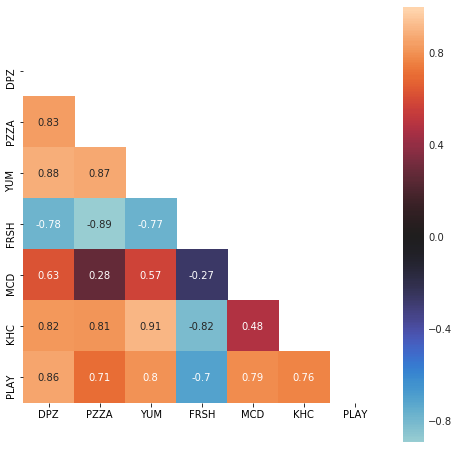

In [7]:
# check linear relationships
corr = px.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)

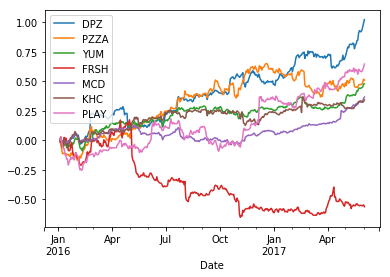

In [146]:
# transform to business day frequency and calculate percentage change
# show cumulative returns over time period of business days
px = px.asfreq('B').fillna(method='pad') # pad == ffill
rets = px.pct_change() #default is one, business day return
((1+rets).cumprod()-1).plot()

In [27]:
# potential reference: https://www.investopedia.com/terms/m/momentum_investing.asp
# compute momentum over a lookback and rank in descending order and standardize to get portfolio weights
# this is not momentum out of the box. this is mean reversion, we can change to momentum by changing asc to Ture
# these form the weights for our portfolio and are based on standardized momentum ranks so we sum to 0 as part of
# our portfolio
# ascending = True - momentum
# ascending = False - mean reversion

def calc_mom(price, lookback, lag):
    '''Calculates pct change based on user input shift and lookback period, ranks, then standardizes ranks'''
    mom_ret = price.shift(lag).pct_change(lookback) # price shift forward lag periods and calc % change based on
                                                    # lookback cumulative return for each day in index
    ranks = mom_ret.rank(axis=1, ascending=True) # rank top performers for each day (ASCENDING = MAXIMIZE STOCKS
                                                  # WITH POSITIVE TREND)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0) # subtract the mean rank for the portfolio for each day
    return demeaned.divide(demeaned.std(axis=1), axis=0) # divide by sd of the ranks for each day to standardize

Now set up backtesting function to calculate a portfolio 

by iterating over lookbacks and holding period

In [45]:
compound = lambda x : (1+x).prod()-1     # compound calc to give us compound returns for each holding period
daily_sr = lambda x : x.mean() / x.std() # calculate mean portfolio return divided by std deviation to get sharpe

# Sharpe Ratio is avg return above risk free rate 
# Subtracting the risk-free rate from the mean return, 
# the performance associated with risk-taking activities can be isolated.
# > sharpe ratio = more attractive risk adjusted return
# (https://www.investopedia.com/terms/s/sharperatio.asp)

def strat_sr(prices, lb, hold):
    # Compute portfolio weights using rank-standardized momentum portfolio
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold) 
    
    # THE ANSWER HAS BEEN REVEALED (regarding sharpe ratio scaling which is an annual value inherently)
    # the scaling factor is an approximation,  
    # We use K as a scaling factor to adjust for the cases when our data is sampled more frequently than annually
    # https://augmentedtrader.com/2015/09/02/why-multiply-by-sqrt252-to-compute-the-sharpe-ratio/

In [46]:
strat_sr(px, 1, 20)

/Users/patrickcorynichols/anaconda/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/patrickcorynichols/anaconda/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


Date
2016-01-04    0.459871
2016-02-01   -0.444506
2016-02-29    0.017804
2016-03-28   -0.259320
2016-04-25   -0.606475
2016-05-23    0.281177
2016-06-20    0.015153
2016-07-18    0.158552
2016-08-15   -0.033380
2016-09-12    0.211209
2016-10-10    0.527768
2016-11-07   -0.201297
2016-12-05    0.031788
2017-01-02   -0.086377
2017-01-30    0.076000
2017-02-27   -0.126448
2017-03-27   -0.423910
2017-04-24    0.195424
2017-05-22    0.113607
dtype: float64

In [106]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(sp, lb, hold)
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [107]:
def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

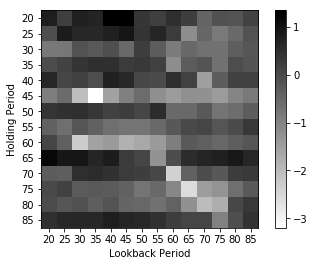

In [108]:
heatmap(ddf)
plt.show()